In [2]:
%pip install git+https://github.com/zalandoresearch/pytorch-ts.git

  Cloning https://github.com/zalandoresearch/pytorch-ts.git to /private/var/folders/s0/2kx6gt090mv4dv8pfv8d86kc0000gn/T/pip-req-build-tznp1pqq
  Running command git clone -q https://github.com/zalandoresearch/pytorch-ts.git /private/var/folders/s0/2kx6gt090mv4dv8pfv8d86kc0000gn/T/pip-req-build-tznp1pqq
  Resolved https://github.com/zalandoresearch/pytorch-ts.git to commit 81be06bcc128729ad8901fcf1c722834f176ac34
  Using cached torch-1.10.2-cp36-none-macosx_10_9_x86_64.whl (147.1 MB)
  Using cached gluonts-0.11.12-py3-none-any.whl (1.0 MB)
     |████████████████████████████████| 172 kB 5.7 MB/s eta 0:00:01
  Using cached numpy-1.19.5-cp36-cp36m-macosx_10_9_x86_64.whl (15.6 MB)
  Using cached pandas-1.1.5-cp36-cp36m-macosx_10_9_x86_64.whl (10.2 MB)
     |████████████████████████████████| 28.8 MB 19.2 MB/s eta 0:00:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached matplotlib-3.3.4-cp36-cp36m-macosx_10_9_x86_64.whl (8.5 MB)
     |████████████████████████████████| 5.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
%pip install pytorch_lightning

  Using cached pytorch_lightning-2.0.1-py3-none-any.whl (716 kB)
  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)
  Using cached lightning_utilities-0.8.0-py3-none-any.whl (20 kB)
  Using cached fsspec-2023.4.0-py3-none-any.whl (153 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 KB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 KB 4.5 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [24]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("solar-energy", regenerate=False)

saving time-series into /Users/shushangnair/.mxnet/gluon-ts/datasets/solar-energy/train/data.json
saving time-series into /Users/shushangnair/.mxnet/gluon-ts/datasets/solar-energy/test/data.json


In [25]:
type(dataset)

gluonts.dataset.common.TrainDatasets

In [26]:
dataset.metadata

MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [27]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [28]:
dataset_train = train_grouper(dataset.train)
# dataset_train*=100
dataset_test = test_grouper(dataset.test)

/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/site-packages/gluonts/dataset/multivariate_grouper.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


In [42]:
dataset

TrainDatasets(metadata=MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24), train=<gluonts.dataset.common.FileDataset object at 0x7fe120480c50>, test=<gluonts.dataset.common.FileDataset object at 0x7fe120480828>)

In [33]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=2,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [34]:
predictor = estimator.train(dataset_train, num_workers=8)

100%|██████████| 99/99 [04:54<00:00,  2.98s/it, epoch=2/2, avg_loss=0.148]


In [57]:
!pip list

Package                 Version
----------------------- ---------
absl-py                 1.4.0
appnope                 0.1.2
backcall                0.2.0
cachetools              4.2.4
certifi                 2021.5.30
charset-normalizer      2.0.12
convertdate             2.3.2
cycler                  0.11.0
dataclasses             0.8
decorator               5.1.1
entrypoints             0.3
gluonts                 0.9.5
google-auth             2.17.2
google-auth-oauthlib    0.4.6
grpcio                  1.48.2
hijri-converter         2.2.4
holidays                0.13
idna                    3.4
importlib-metadata      4.8.3
importlib-resources     5.4.0
ipykernel               5.3.4
ipython                 7.16.1
ipython-genutils        0.2.0
jedi                    0.17.0
jupyter-client          7.1.2
jupyter-core            4.8.1
kiwisolver              1.3.1
korean-lunar-calendar   0.3.1
Markdown                3.3.7
matplotlib              3.3.4
nest-asyncio            1.5.1
n

In [35]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [36]:
forecasts = list(forecast_it)
targets = list(ts_it)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe1203ebf98>>
Traceback (most recent call last):
  File "/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1304, in _shutdown_workers
    q.close()
  File "/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/shushangnair/anaconda3/envs/ml3/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


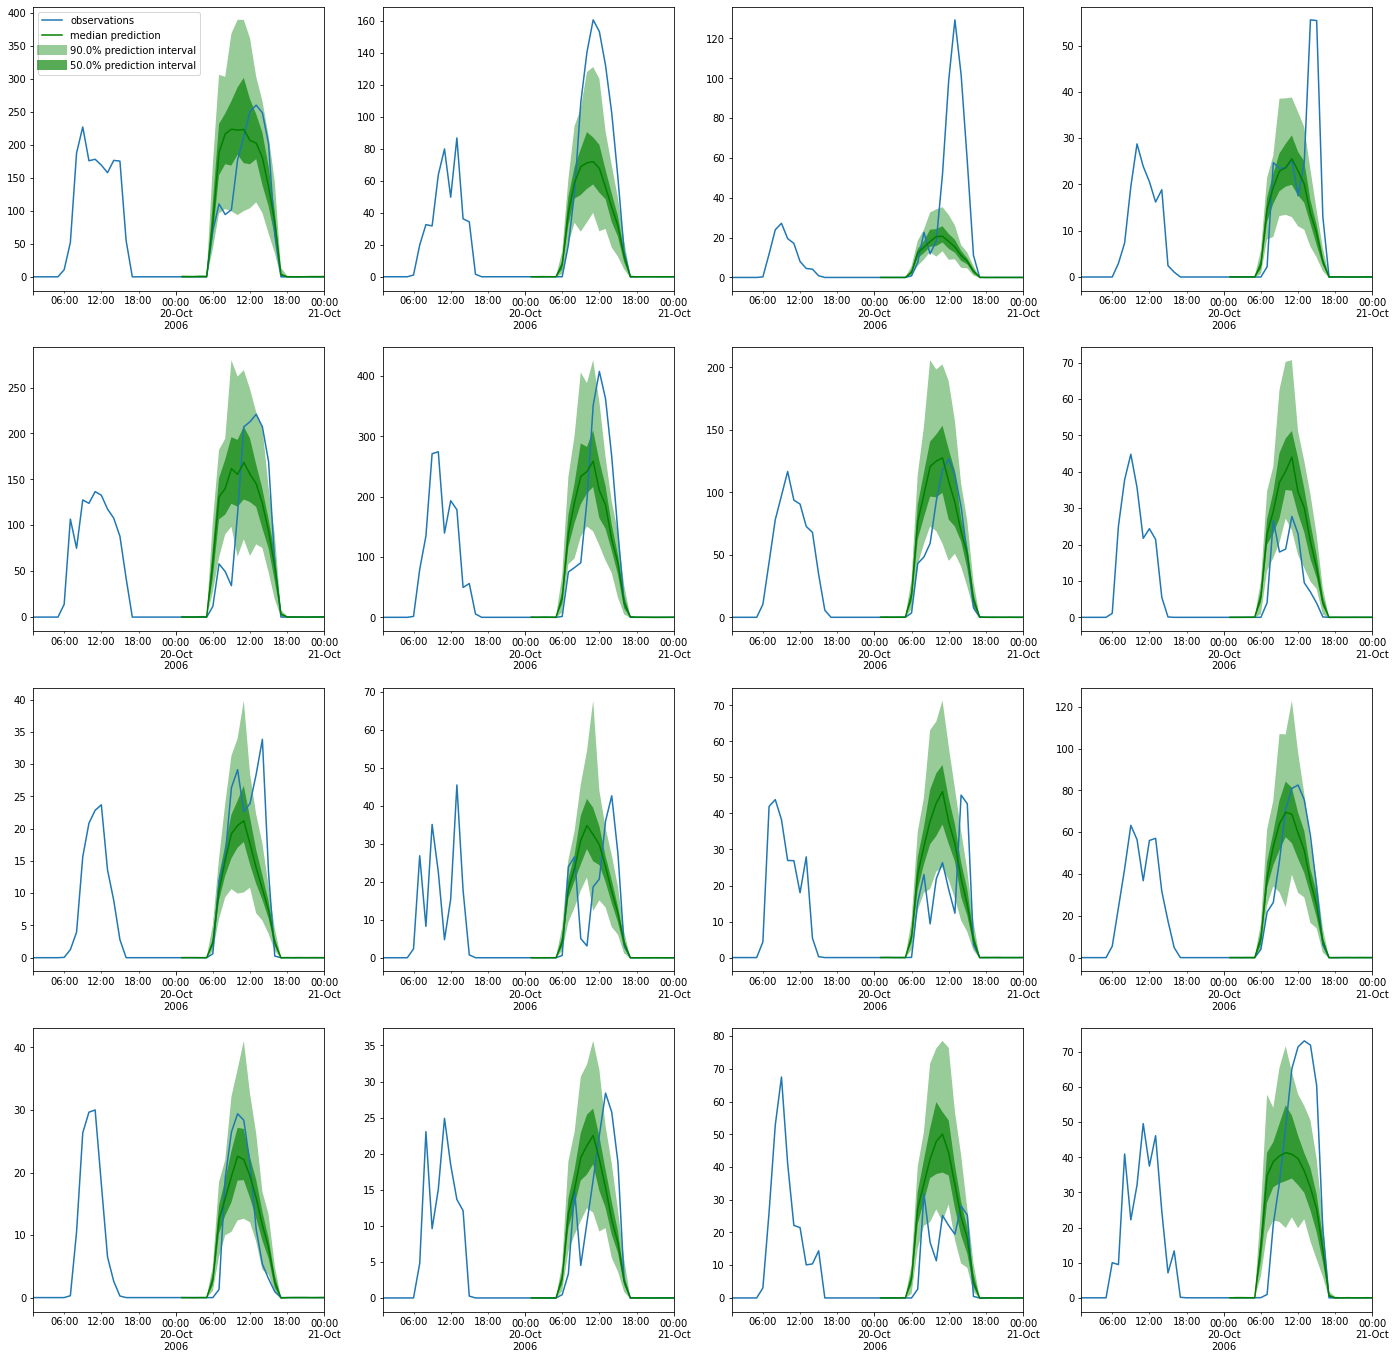

In [37]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [38]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [39]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 78.62it/s]
Running evaluation: 7it [00:00, 90.31it/s]
Running evaluation: 7it [00:00, 92.80it/s]
Running evaluation: 7it [00:00, 91.63it/s]
Running evaluation: 7it [00:00, 91.64it/s]
Running evaluation: 7it [00:00, 91.71it/s]
Running evaluation: 7it [00:00, 91.48it/s]
Running evaluation: 7it [00:00, 89.71it/s]
Running evaluation: 7it [00:00, 91.21it/s]
Running evaluation: 7it [00:00, 89.88it/s]
Running evaluation: 7it [00:00, 91.27it/s]
Running evaluation: 7it [00:00, 88.41it/s]
Running evaluation: 7it [00:00, 85.78it/s]
Running evaluation: 7it [00:00, 89.53it/s]
Running evaluation: 7it [00:00, 92.25it/s]
Running evaluation: 7it [00:00, 91.68it/s]
Running evaluation: 7it [00:00, 90.81it/s]
Running evaluation: 7it [00:00, 89.34it/s]
Running evaluation: 7it [00:00, 85.66it/s]
Running evaluation: 7it [00:00, 87.23it/s]
Running evaluation: 7it [00:00, 88.34it/s]
Running evaluation: 7it [00:00, 91.57it/s]
Running evaluation: 7it [00:00, 93.17it/s]
Running eva

In [40]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.4521980904359451
ND: 0.5649930492122808
NRMSE: 1.1674936906009028

CRPS-Sum: 0.4880306290466804
ND-Sum: 0.5369787185622814
NRMSE-Sum: 0.946582438441549
